In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x[0:7])
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x[0:4])

In [3]:
df_customers = pd.read_csv('customers.csv')
cols = ['customer_id']
cols.extend(df_customers.columns[1:])
df_customers.columns = cols

In [4]:
df_orders.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year
1576,158554,2015-11-09,Same Day,CM-12190,11.352,2015-11,2015
2601,158260,2016-11-04,Standard,CC-12475,686.400,2016-11,2016
2657,161543,2016-05-10,Standard,RD-19720,11.960,2016-05,2016
3589,139773,2017-12-04,Same Day,DV-13045,188.552,2017-12,2017
1241,133452,2015-04-13,Standard,ZC-21910,910.792,2015-04,2015


In [5]:
df_customers.sample(5)

,customer_id,name,segment,state,city
75,EM-13960,Eric Murdock,Consumer,Pennsylvania,Philadelphia
682,BF-11215,Benjamin Farhat,Home Office,New Mexico,Albuquerque
674,JB-16045,Julia Barnett,Home Office,Georgia,Columbus
429,LW-16825,Laurel Workman,Corporate,Florida,Deltona
24,DP-13000,Darren Powers,Consumer,Indiana,New Albany


In [6]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')

In [7]:
df_merge.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city
1336,111416,2016-09-17,Standard,LW-17215,232.400,2016-09,2016,Luke Weiss,Consumer,California,Pasadena
4223,133025,2015-09-17,Second,MO-17800,32.400,2015-09,2015,Meg O'Connel,Home Office,New York,New York City
4170,100671,2016-11-01,First,CS-12490,111.672,2016-11,2016,Cindy Schnelling,Corporate,Texas,Conroe
3347,108259,2015-11-08,Standard,NS-18640,81.135,2015-11,2015,Noel Staavos,Corporate,Illinois,Chicago
2871,154718,2017-01-19,Second,DL-12865,6.000,2017-01,2017,Dan Lawera,Consumer,Ohio,Cincinnati


In [30]:
df_first = df_merge.groupby('customer_id')['order_year'].min().reset_index()
df_first.columns = ['customer_id', 'first_order']

In [31]:
df_first.sample(5)

,customer_id,first_order
738,TB-21520,2014
469,LR-16915,2014
560,NF-18385,2014
63,AZ-10750,2014
599,PM-18940,2014


In [32]:
df_full = pd.merge(df_merge, df_first, 'inner', on='customer_id')

In [33]:
df_full.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
407,113292,2016-03-18,Second,DB-13060,871.800,2016-03,2016,Dave Brooks,Consumer,Washington,Seattle,2014
866,117345,2014-08-01,Standard,BF-10975,202.896,2014-08,2014,Barbara Fisher,Corporate,North Carolina,Charlotte,2014
3446,168564,2015-08-08,Same Day,TT-21220,158.672,2015-08,2015,Thomas Thornton,Consumer,Texas,Houston,2014
2511,113593,2015-04-18,First,NC-18415,115.440,2015-04,2015,Nathan Cano,Consumer,North Carolina,Jacksonville,2014
346,125997,2014-09-20,First,MW-18220,3519.370,2014-09,2014,Mitch Webber,Consumer,New York,New York City,2014


In [34]:
df_users = df_full.groupby(['customer_id', 'first_order', 'order_year', 'ship_mode', 'segment', 'state'])\
    .agg({'sales':'sum', 'id':'count'}).reset_index()

In [35]:
df_users.sample(5)

,customer_id,first_order,order_year,ship_mode,segment,state,sales,id
7,AA-10375,2014,2016,Second,Consumer,Arizona,513.520,1
2549,MZ-17515,2014,2016,Standard,Corporate,California,22.160,1
561,CA-12310,2014,2014,Standard,Corporate,Ohio,455.230,1
3456,TC-21145,2017,2017,Standard,Corporate,New Jersey,1038.260,1
408,BH-11710,2014,2014,Standard,Consumer,California,4523.232,2


In [204]:
def get_retention(df):
    for col in df.columns[:-1]:
        df[col] = round(df[col] / df['Base'], 3)
    return df

### Customer retention

In [205]:
df = pd.crosstab(df_users.first_order, df_users.order_year, values=df_users['customer_id'], aggfunc='nunique')
df['Base'] = np.diag(df)
customer_retention = get_retention(df)
customer_retention

order_year,2014,2015,2016,2017,Base
first_order,,,,,
2014,1.0,0.734,0.815,0.869,595.0
2015,NaN,1.000,0.750,0.882,136.0
2016,NaN,NaN,1.000,0.882,51.0
2017,NaN,NaN,NaN,1.000,11.0


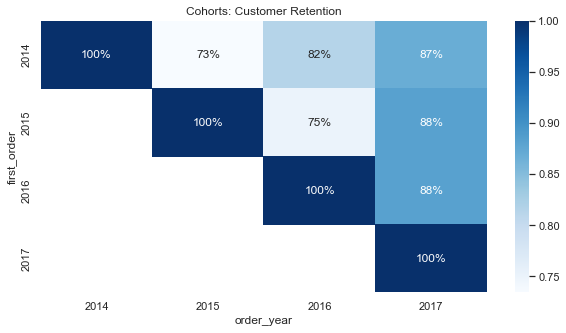

In [206]:
sns.set(style='white')
plt.figure(figsize=(10, 5))
plt.title('Cohorts: Customer Retention')
sns.heatmap(customer_retention.iloc[:, :-1], mask=customer_retention.iloc[:, :-1].isnull(), annot=True, fmt='.0%', cmap="Blues")

### Customer retention by segment

In [212]:
df = pd.crosstab(
    [df_users.segment, df_users.first_order],
    df_users.order_year,
    values=df_users['customer_id'],
    aggfunc='nunique')
df['Base'] = df.stack().groupby(level=[0,1]).first()
customer_retention_segment = get_retention(df)
customer_retention_segment

order_year               2014   2015   2016   2017   Base
segment     first_order                                  
Consumer    2014          1.0  0.743  0.830  0.878  311.0
            2015          NaN  1.000  0.719  0.891   64.0
            2016          NaN    NaN  1.000  0.889   27.0
            2017          NaN    NaN    NaN  1.000    7.0
Corporate   2014          1.0  0.704  0.821  0.860  179.0
            2015          NaN  1.000  0.821  0.897   39.0
            2016          NaN    NaN  1.000  0.800   15.0
            2017          NaN    NaN    NaN  1.000    3.0
Home Office 2014          1.0  0.762  0.762  0.857  105.0
            2015          NaN  1.000  0.727  0.848   33.0
            2016          NaN    NaN  1.000  1.000    9.0
            2017          NaN    NaN    NaN  1.000    1.0

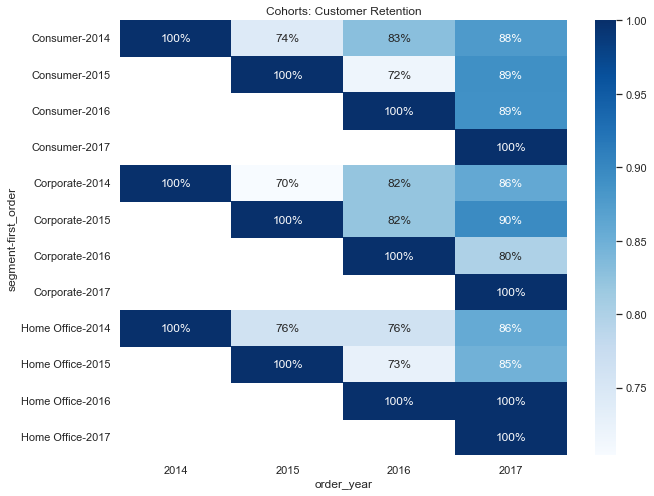

In [213]:
sns.set(style='white')
plt.figure(figsize=(10, 8))
plt.title('Cohorts: Customer Retention')
sns.heatmap(
    customer_retention_segment.iloc[:, :-1],
    mask=customer_retention_segment.iloc[:, :-1].isnull(),
    annot=True, fmt='.0%', cmap="Blues")

### Customer retention by ship_mode

In [220]:
df_users.head()

,customer_id,first_order,order_year,ship_mode,segment,state,sales,id
0,AA-10315,2014,2014,Standard,Consumer,Minnesota,756.048,2
1,AA-10315,2014,2015,First,Consumer,Minnesota,26.960,1
2,AA-10315,2014,2016,Standard,Consumer,Minnesota,4406.072,1
3,AA-10315,2014,2017,Standard,Consumer,Minnesota,374.480,1
4,AA-10375,2014,2014,Standard,Consumer,Arizona,50.792,2


In [228]:
df = pd.crosstab(
    [df_users.ship_mode, df_users.first_order],
    df_users.order_year,
    values=df_users['customer_id'],
    aggfunc='nunique')
df['Base'] = df.stack().groupby(level=[0,1]).first()
customer_retention_ship = get_retention(df)
customer_retention_ship

order_year             2014   2015   2016   2017   Base
ship_mode first_order                                  
First     2014          1.0  0.788  1.038  1.273  132.0
          2015          NaN  1.000  1.276  1.517   29.0
          2016          NaN    NaN  1.000  1.167   18.0
          2017          NaN    NaN    NaN  1.000    3.0
Same Day  2014          1.0  0.915  1.170  1.426   47.0
          2015          NaN  1.000  1.333  1.556    9.0
          2016          NaN    NaN  1.000  2.500    2.0
Second    2014          1.0  0.786  0.942  1.150  173.0
          2015          NaN  1.000  0.714  0.929   42.0
          2016          NaN    NaN  1.000  0.944   18.0
          2017          NaN    NaN    NaN  1.000    3.0
Standard  2014          1.0  0.770  0.862  0.943  435.0
          2015          NaN  1.000  0.806  1.041   98.0
          2016          NaN    NaN  1.000  0.900   40.0
          2017          NaN    NaN    NaN  1.000    8.0

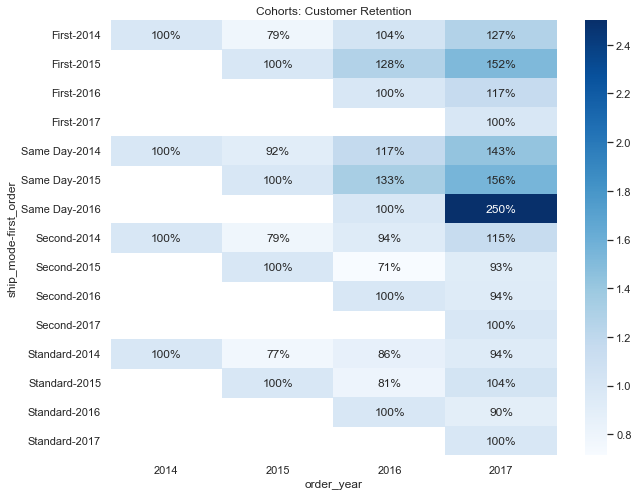

In [229]:
sns.set(style='white')
plt.figure(figsize=(10, 8))
plt.title('Cohorts: Customer Retention')
sns.heatmap(
    customer_retention_ship.iloc[:, :-1],
    mask=customer_retention_ship.iloc[:, :-1].isnull(),
    annot=True, fmt='.0%', cmap="Blues")

## Ответ
#### 1. В целом доля уникальных пользователей, которые продолжают совершать покупки, для 2017 года выше , чем в 2016.
#### 2. Но для некоторых когорт хуже: 
#### - В разрезе типа клиента
    - Segment: Corporate, first order=2016 - ретеншен ниже, чем в 2016 для когорт с first order 2014-2015
#### 3 В разрезе типа доставки видно, что в 2017 больше уникальных клиентов стали пользоваться Same Day и First

